In [1]:
%load_ext autoreload
%autoreload 2

### General imports 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

### Custom functions
import sys
sys.path.append('../python')
from functions import *
from models import *

### ML-related
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-05-25 15:11:58.630954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-25 15:11:58.658170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-05-25 15:11:58.658627: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-25 15:11:58.661370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-25 15:11:58.664245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-25 15:11:58.664809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-0

### Load the optimized tail file from a previous training

In [7]:
test = pd.read_hdf("../trained_models/foundtail_size128_batch10000_epochs2000_again/df_test.h5")
test.α = test.α + 212.7
test.δ = test.δ + 55.2

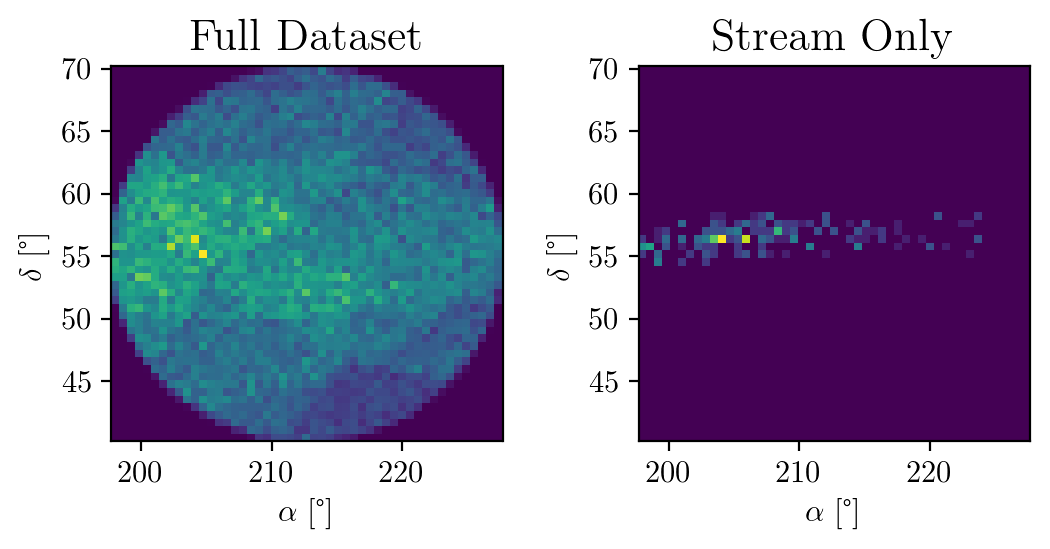

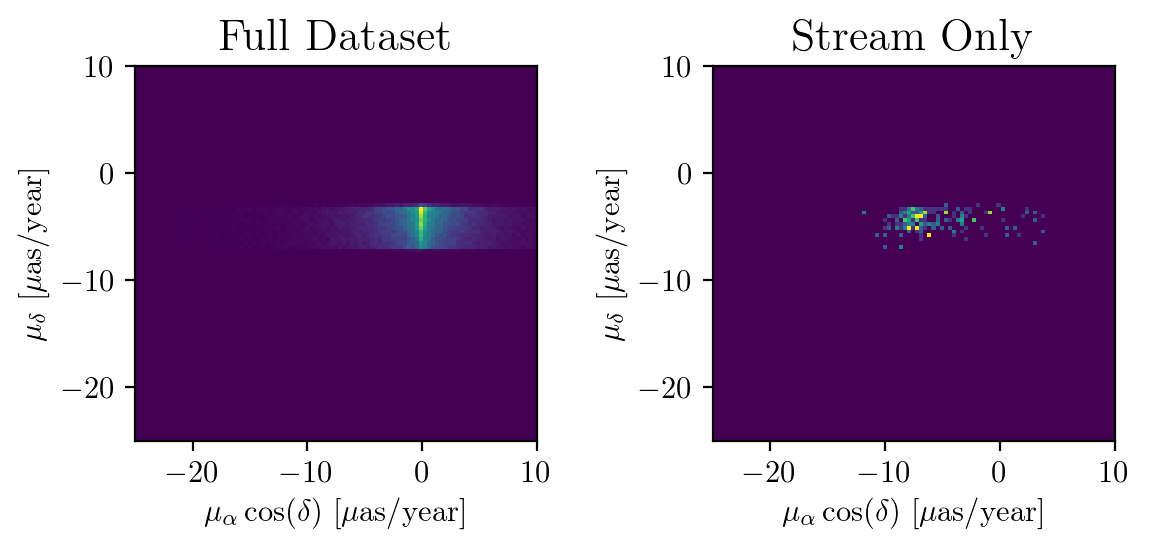

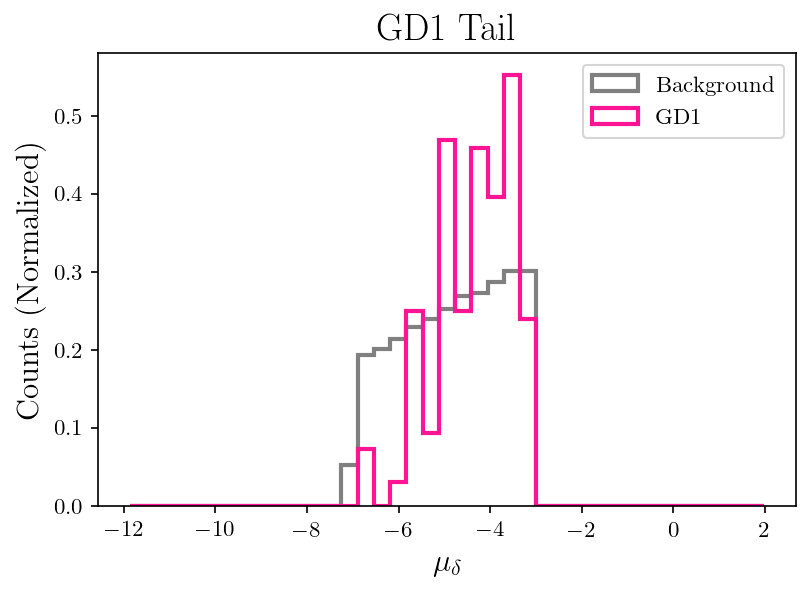

In [8]:
visualize_stream(test)

Maximum purity of 30.8% at 0.01%
Top 10 stars: Purity = 30.0% 
Top 20 stars: Purity = 40.0% 
Top 50 stars: Purity = 52.0% 
Top 100 stars: Purity = 43.0% 


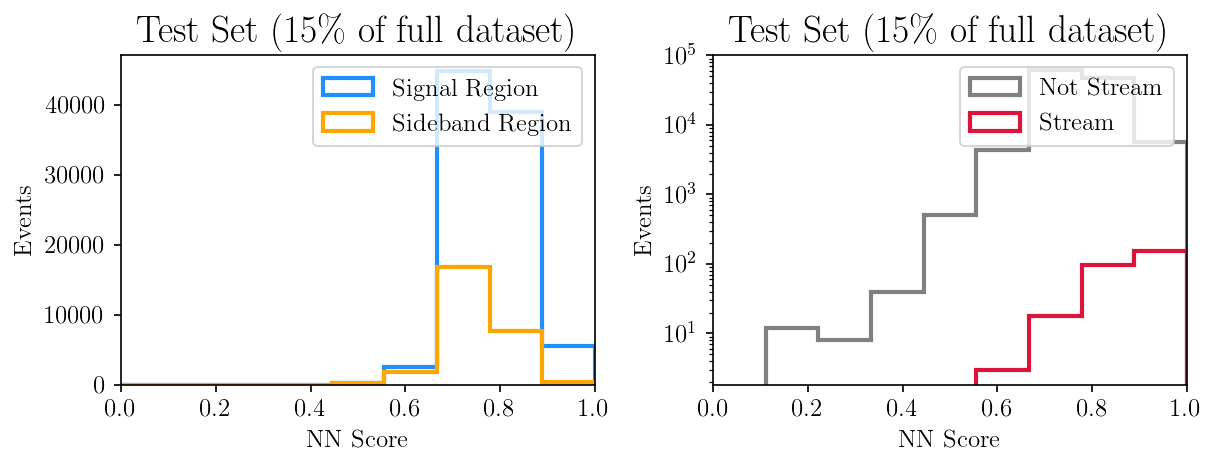

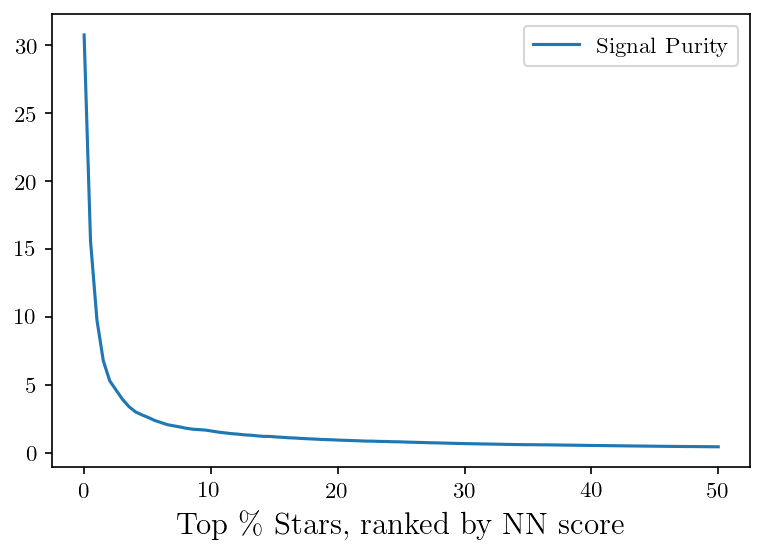

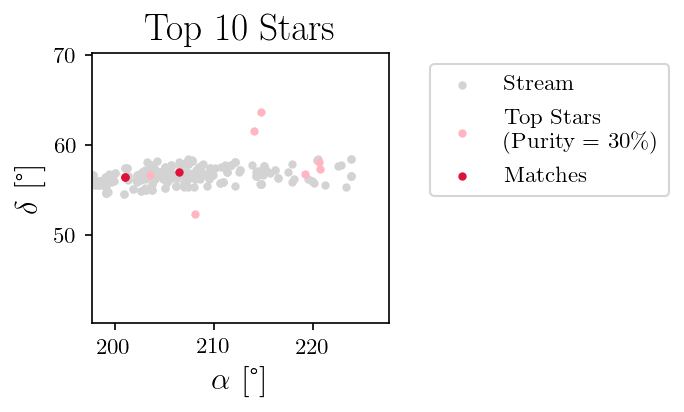

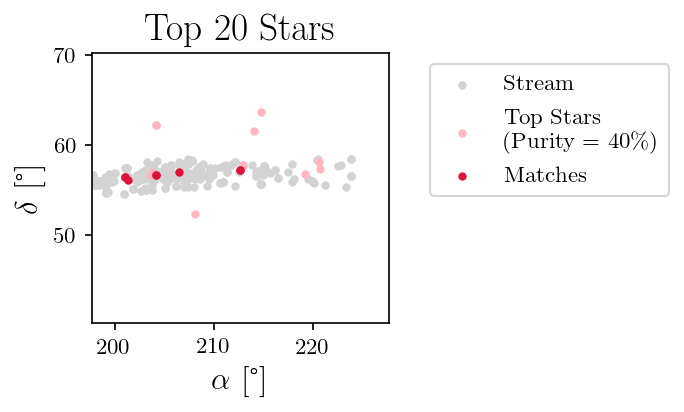

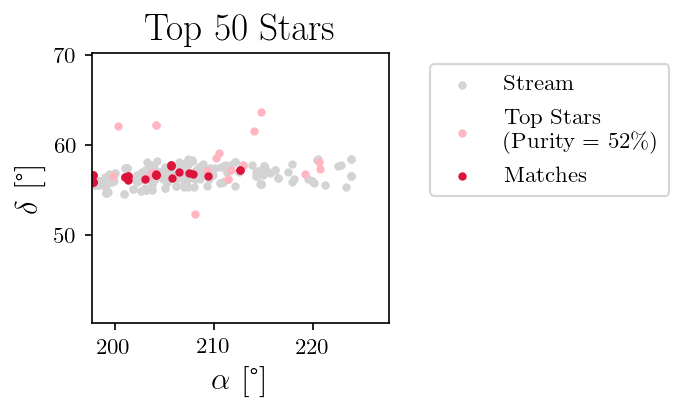

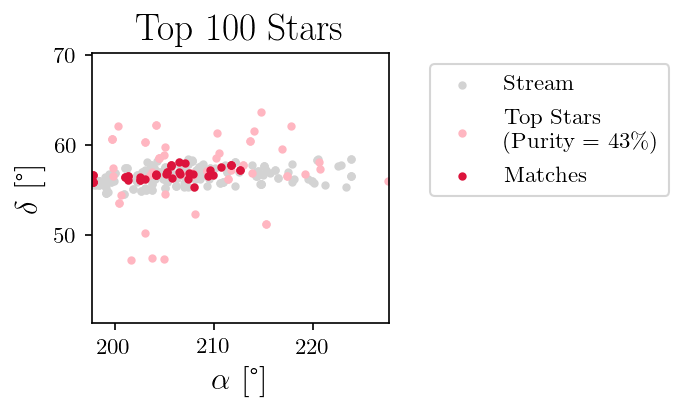

In [9]:
plot_results(test)

### Now let's investigate the stars that look plausibly stream-like but are not labeled as part of the stream

In [10]:
n_top_stars = 50
top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars] # pick the top ranked stars 

# sort by labeled and unlabeled 
labeled = top_stars[top_stars.stream]
unlabeled = top_stars[top_stars.stream == False]

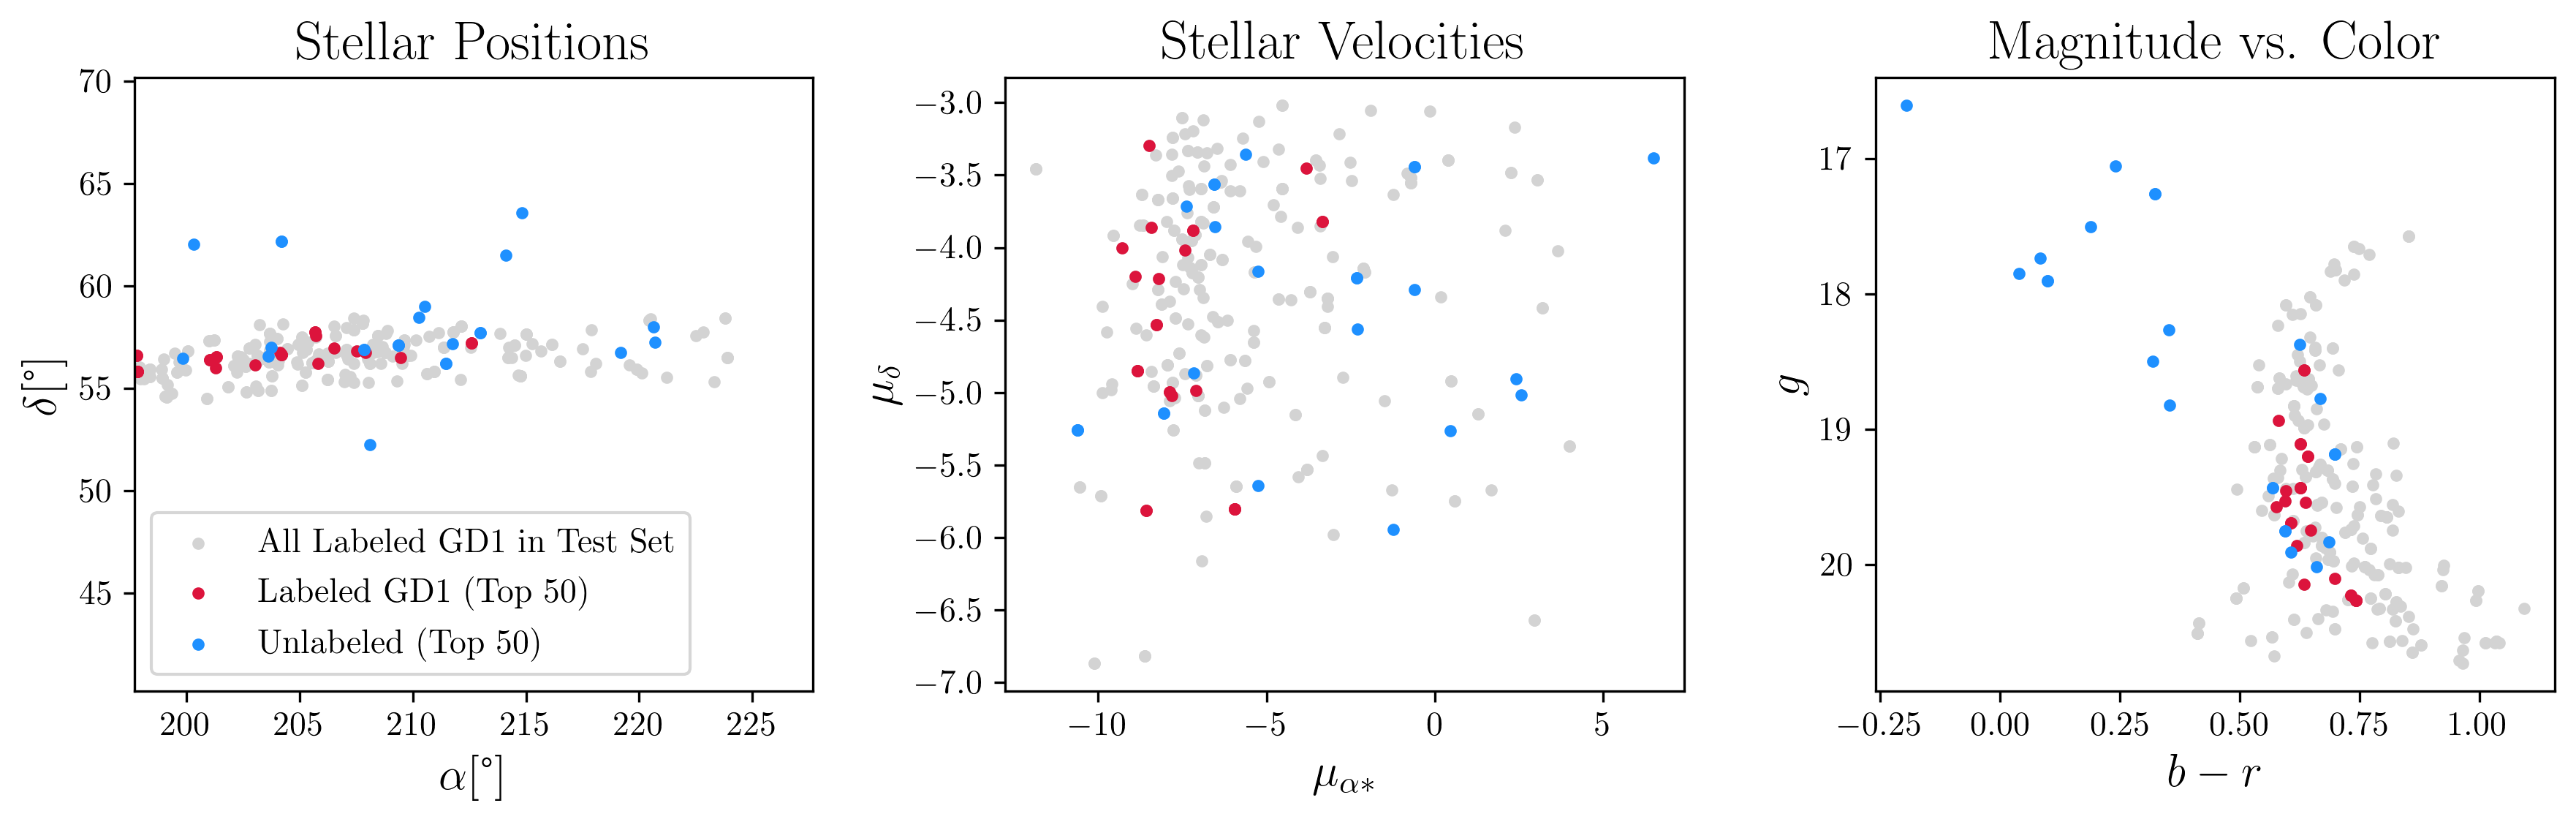

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
# ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α*np.cos(test[test.stream].δ), test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α*np.cos(labeled.δ), labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α*np.cos(unlabeled.δ), unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha *}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_ylim(ax.get_ylim()[::-1]) # reverse y axis to match Via Machinae plot
ax.set_xlabel(r"$b-r$")
ax.set_ylabel(r"$g$");
plt.savefig("../plots/mislabeled_triptych.png")
plt.savefig("../plots/mislabeled_triptych.pdf")

Isolate the unlabeled stars that look close to the stream stars in velocity space...

In [25]:
promising = unlabeled[unlabeled.color > 0.5]

In [26]:
len(promising)

12

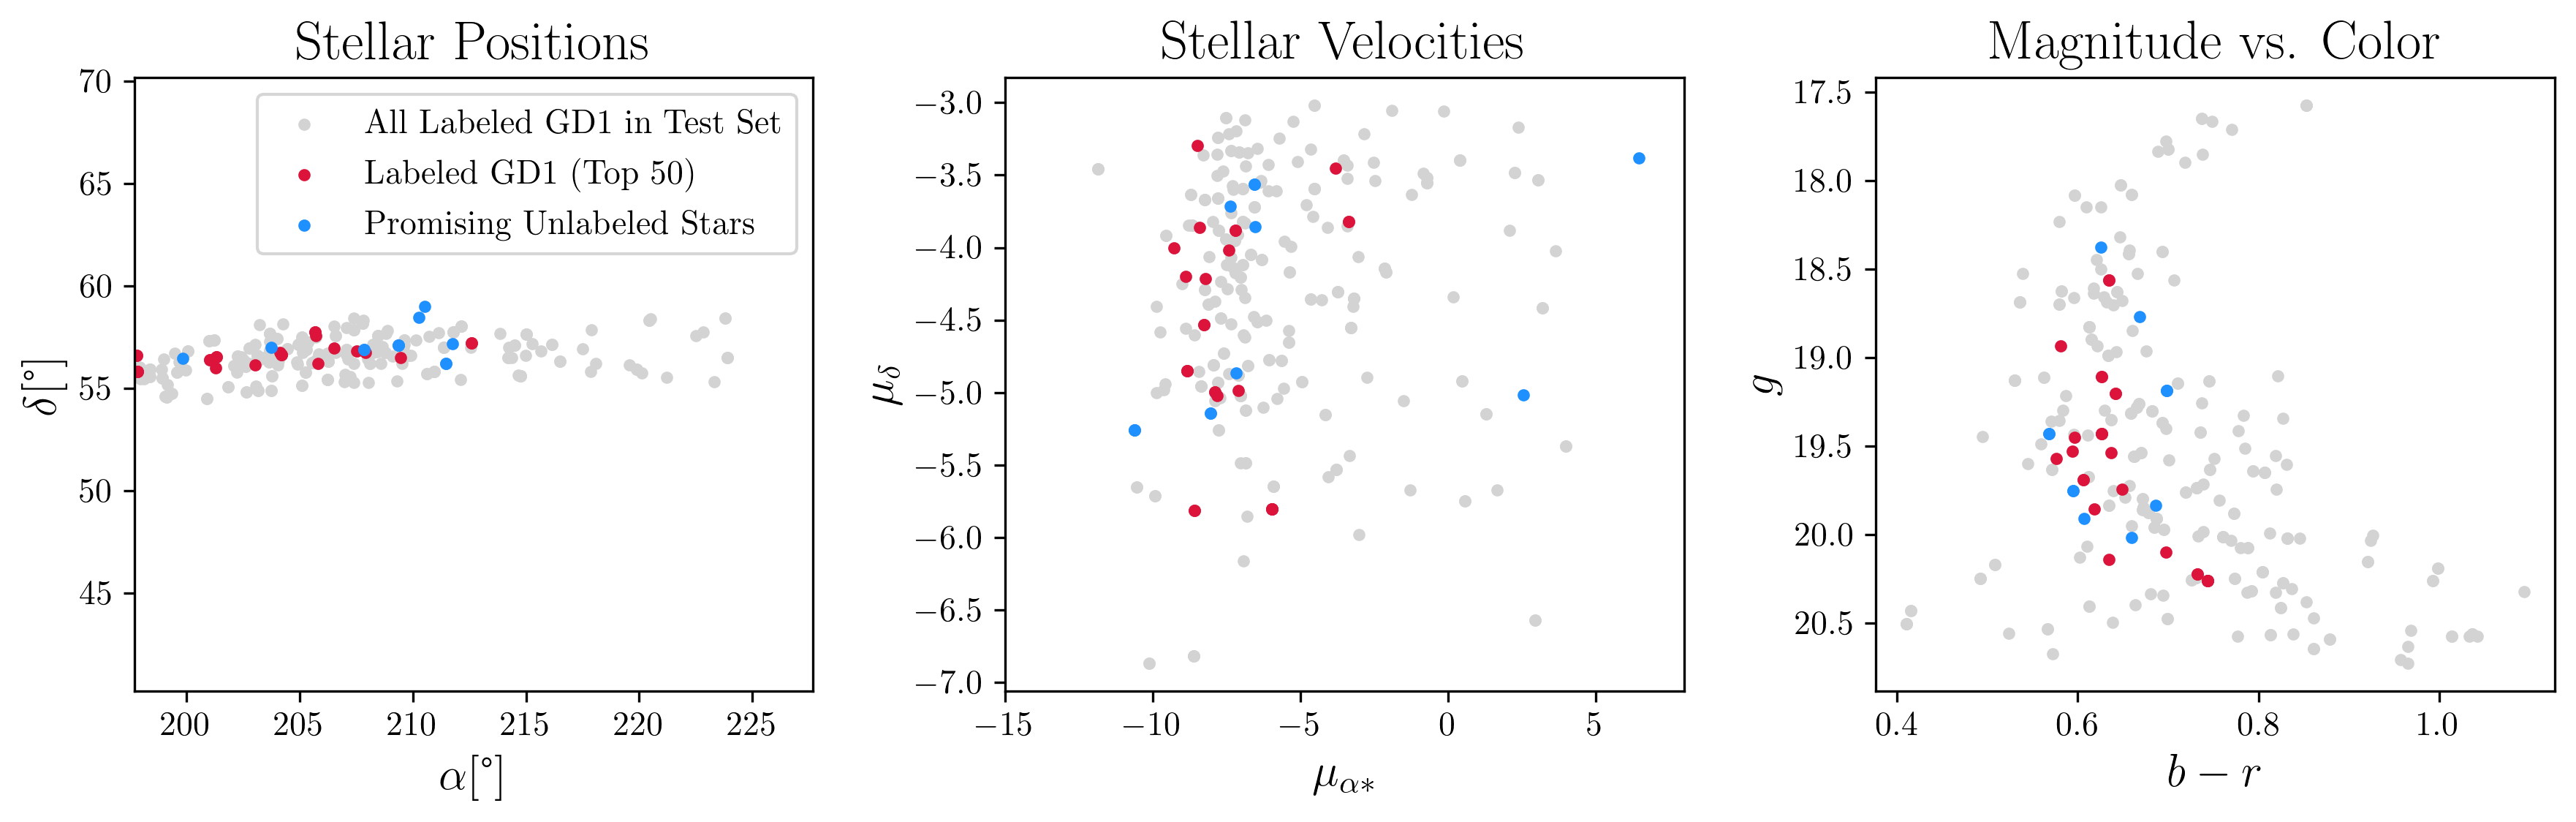

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True, dpi=300)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α*np.cos(test[test.stream].δ), test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α*np.cos(labeled.δ), labeled.μ_δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.μ_α*np.cos(promising.δ), promising.μ_δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,8)
# ax.set_ylim(-7,-3)
ax.set_xlabel(r"$\mu_{\alpha *}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_ylim(ax.get_ylim()[::-1]) # reverse y axis to match Via Machinae plot
ax.set_xlabel(r"$b-r$")
ax.set_ylabel(r"$g$");
plt.savefig("../plots/promising_triptych.png")
plt.savefig("../plots/promising_triptych.pdf")

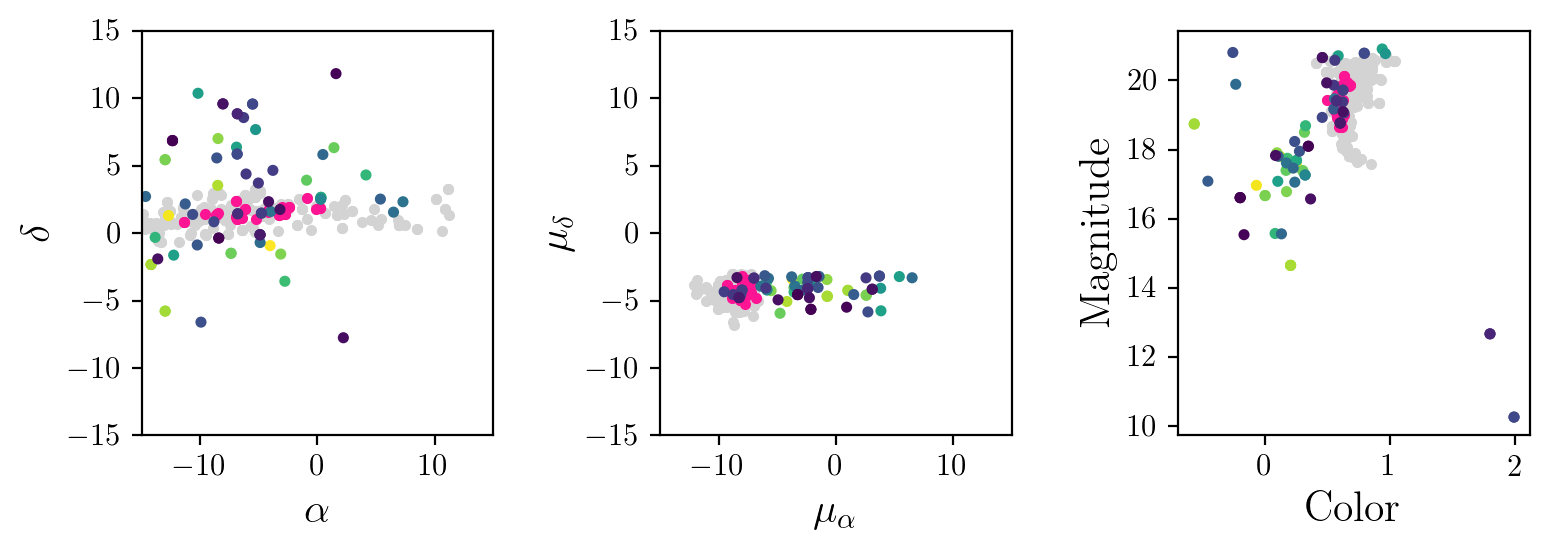

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,3), tight_layout=True, dpi=200)

ax = axs[0]
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\delta$");

ax = axs[1]
ax.scatter(test[test.stream].μ_α, test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");

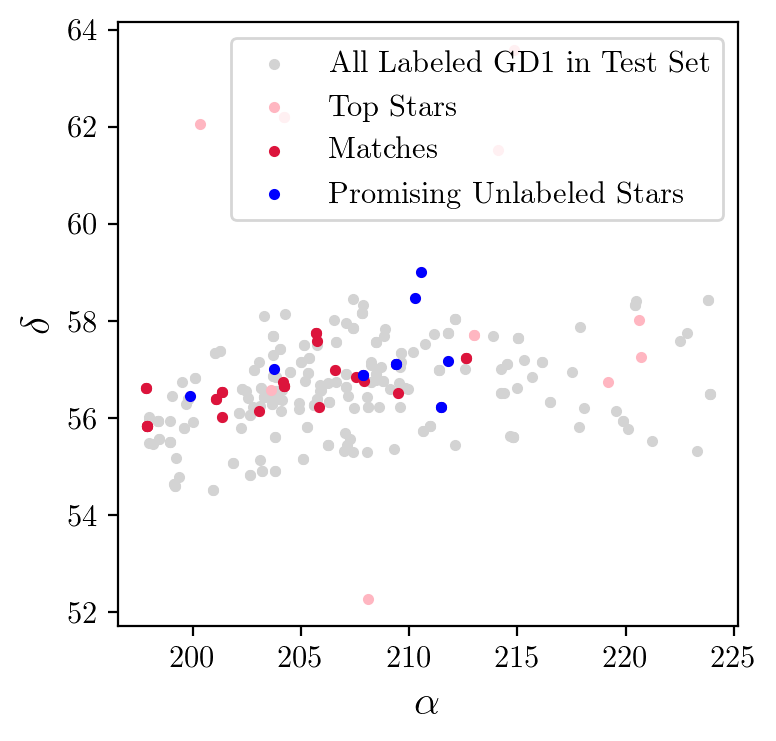

In [31]:
plt.figure(figsize=(4,4), dpi=200)
plt.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
plt.scatter(top_stars.α, top_stars.δ, marker='.', color="lightpink", label="Top Stars")
plt.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Matches")
plt.scatter(promising.α, promising.δ, marker='.', color="blue", label="Promising Unlabeled Stars")
# plt.xlim(-15,15)
# plt.ylim(-15,15)
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$");

What are the distances along the 5 dimensions to the true stream stars in the test set? 

In [32]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]

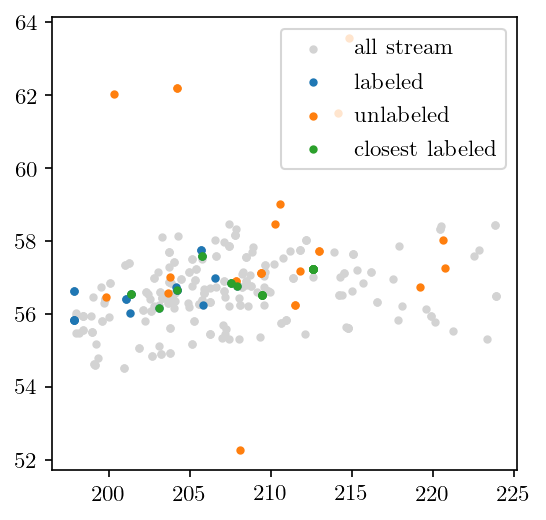

In [33]:
fig = plt.figure(figsize=(4,4), dpi=150)
plt.scatter(test[test.stream].α, test[test.stream].δ, color="lightgray", marker='.', label="all stream")
plt.scatter(labeled.α, labeled.δ, label="labeled", marker='.')
plt.scatter(unlabeled.α, unlabeled.δ, label="unlabeled", marker='.')
plt.scatter(closest_labeled.α, closest_labeled.δ, label="closest labeled", marker='.')
plt.legend()
# plt.xlim(-15,15)
# plt.ylim(-15,15);

In [36]:
closest_dists = distance_matrix(closest_labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
# closest_labeled = unlabeled.iloc[dists.argmin(axis=0)]

In [37]:
closest_labeled[cols]

,μ_α,δ,α,color,mag
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1925921,-8.681205,56.760329,207.907561,0.596670,19.451315
721452,-8.038037,56.152720,203.060332,0.636806,19.538103
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
1564233,-9.310221,57.235926,212.604232,0.606546,19.689514
2740531,-8.893791,56.656626,204.205779,0.626274,19.430170


In [38]:
unlabeled[cols]

,μ_α,δ,α,color,mag
2098689,-6.119520,58.020800,220.630553,0.039171,17.850193
1631390,-7.172117,63.581549,214.817824,0.353991,18.822933
2655773,-5.662166,52.274302,208.097686,0.351412,18.264431
2408995,0.462582,56.582888,203.615447,0.083139,17.735641
22604,-6.971584,57.264765,220.710097,0.188992,17.505329
792168,-4.751844,61.524565,214.107390,0.318102,18.499567
25214,-5.743187,56.746985,219.188033,0.240934,17.056585
988155,-5.875774,57.712733,212.976928,0.323551,17.263399
1569177,-5.875774,57.712733,212.976928,0.323551,17.263399
906846,-8.204379,57.002078,203.743362,0.625576,18.374758


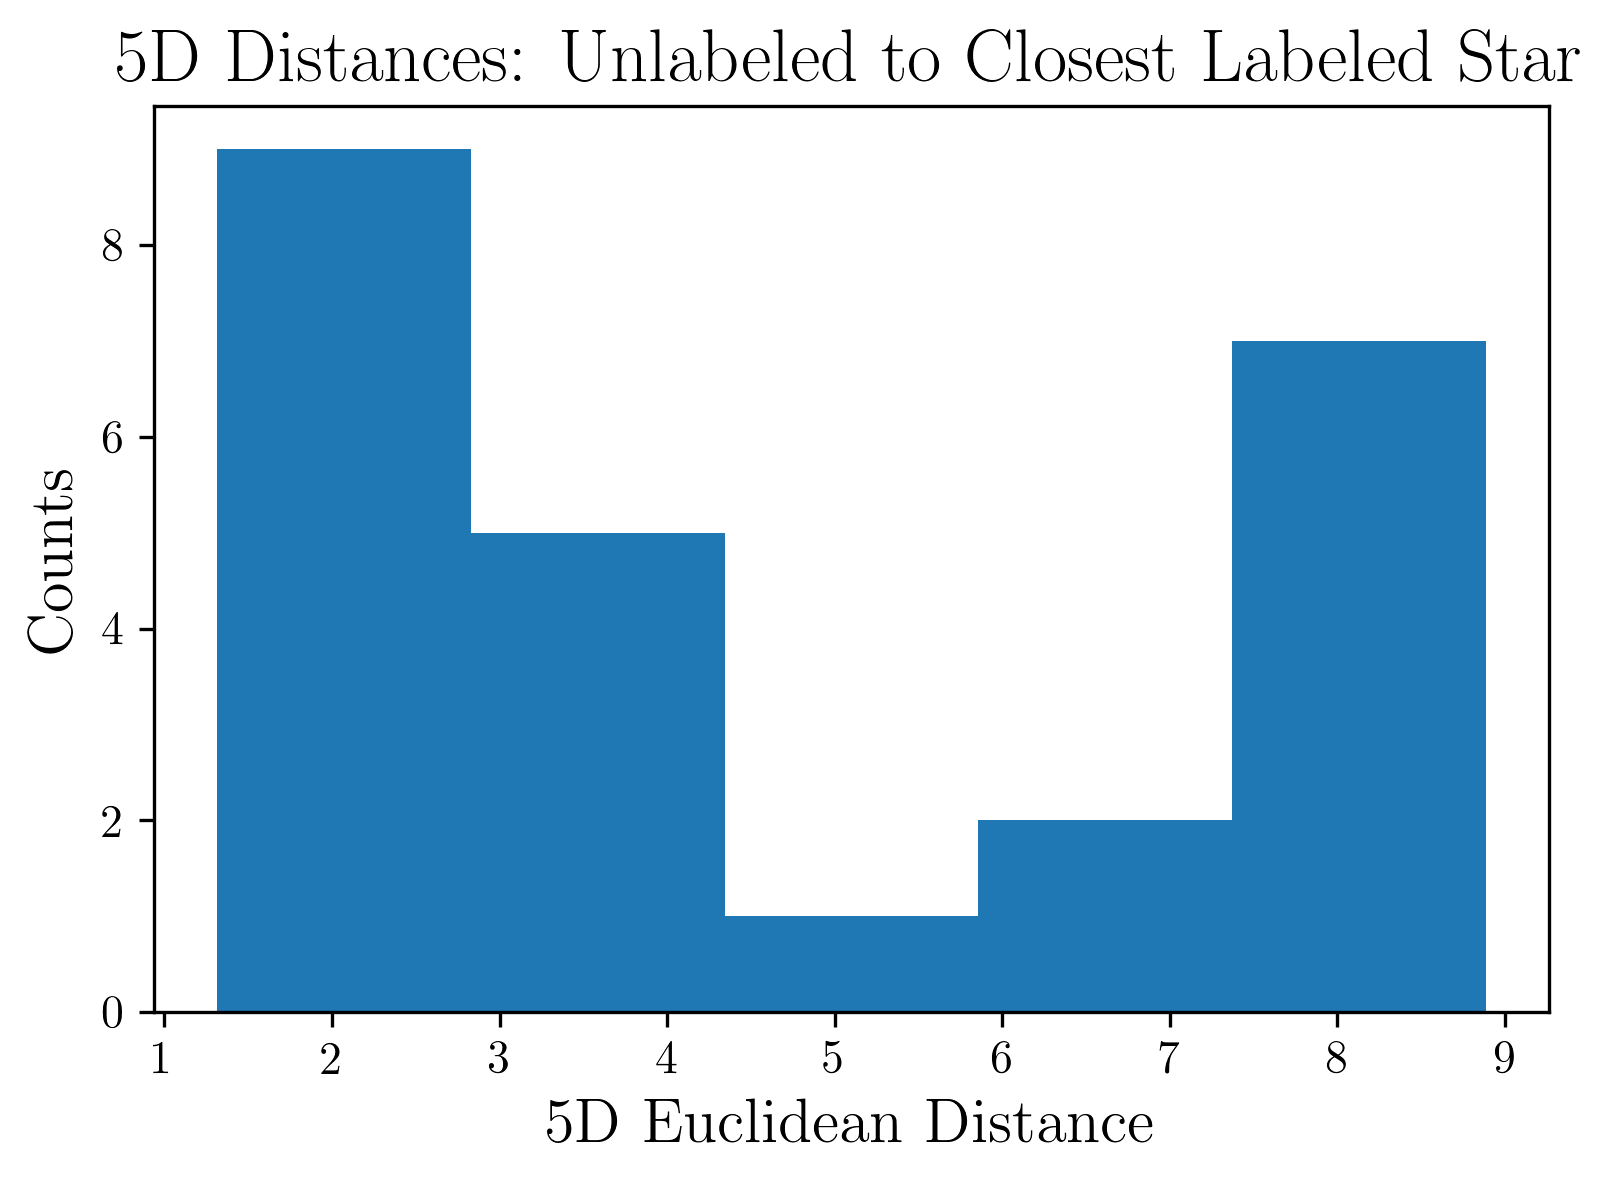

In [52]:
plt.figure(dpi=300)
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
plt.hist(distances, bins=5)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance")
plt.savefig("../plots/5d_distance.png")

In [53]:
unlabeled['5d_distance'] = distances

/tmp/ipykernel_9055/3539591142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled['5d_distance'] = distances


In [54]:
promising = unlabeled[(unlabeled['5d_distance'] < 4)]

In [59]:
len(labeled)

26

In [61]:
26/50

0.52

In [63]:
(len(labeled)+len(promising))/50

0.76

In [55]:
len(promising)

12

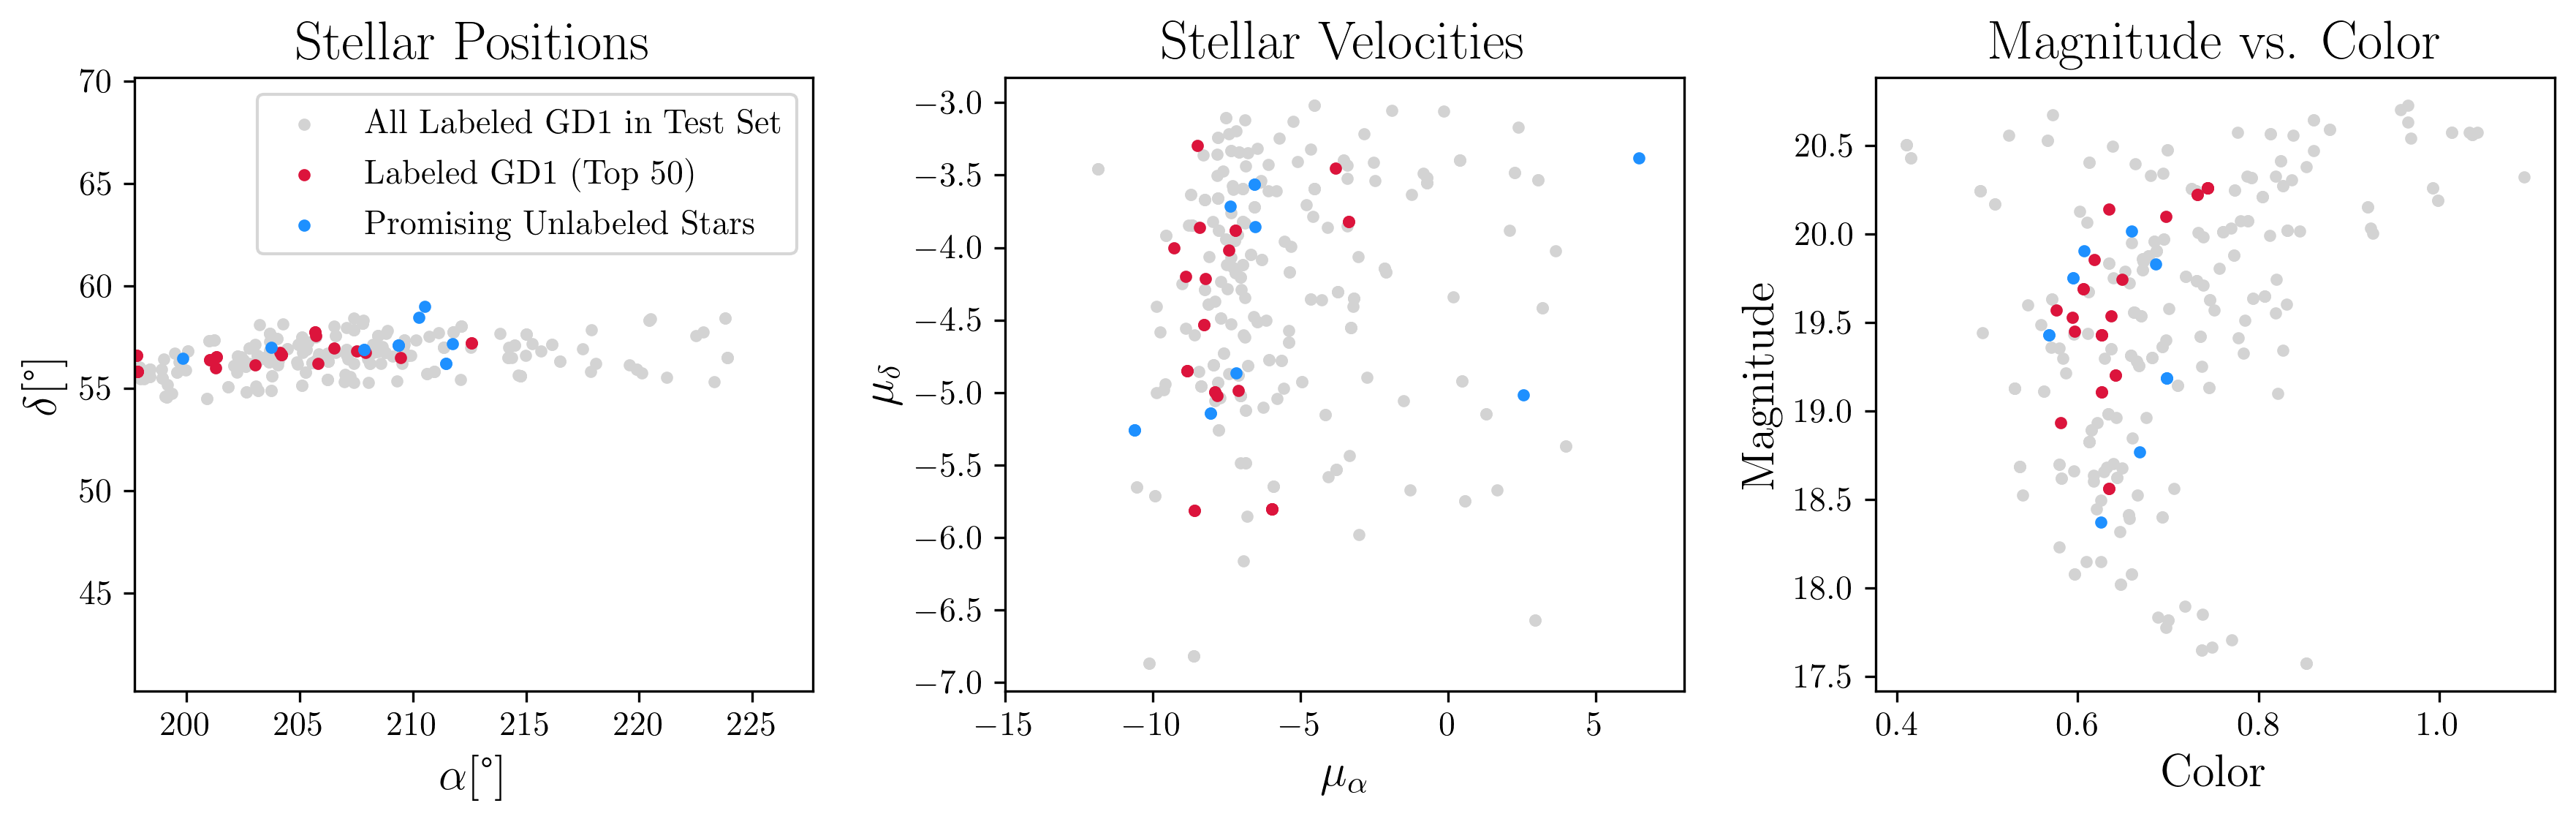

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True, dpi=300)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α*np.cos(test[test.stream].δ), test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α*np.cos(labeled.δ), labeled.μ_δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.μ_α*np.cos(promising.δ), promising.μ_δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,8)
# ax.set_ylim(-7,-3)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
plt.savefig("../plots/promising_triptych.png")
plt.savefig("../plots/promising_triptych.pdf")

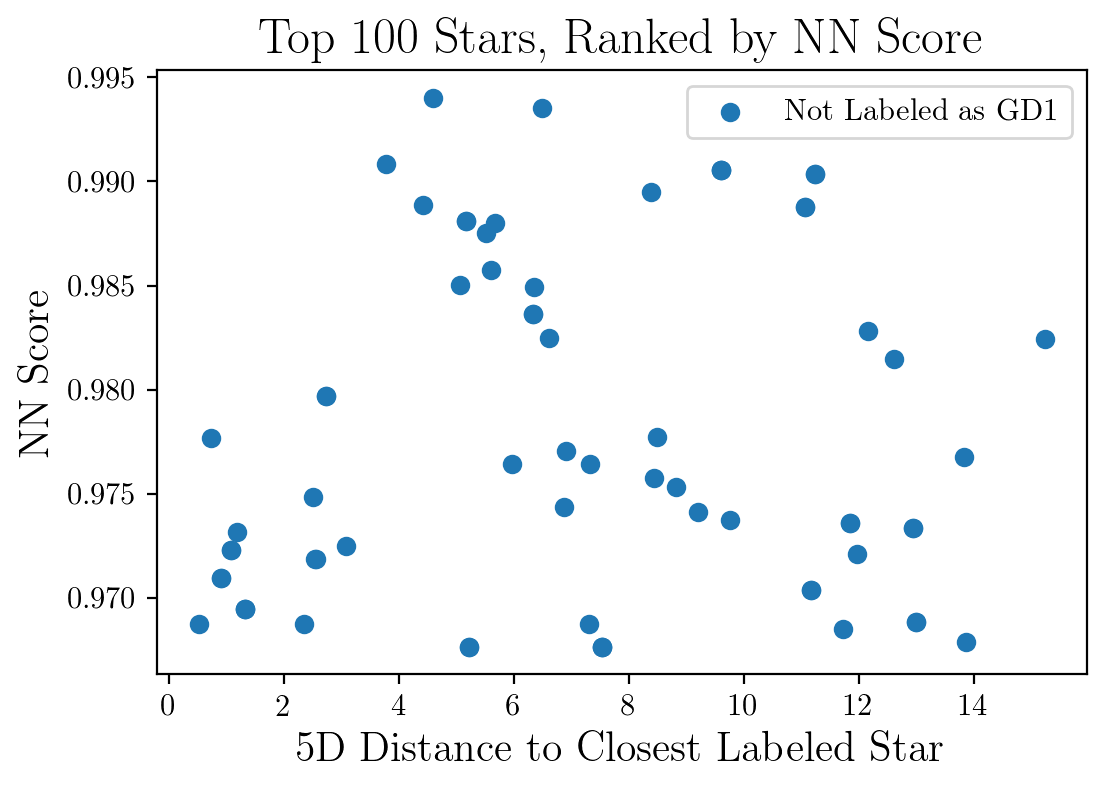

In [77]:
plt.figure(dpi=200)
# plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Labeled as GD1")
plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Not Labeled as GD1")
plt.xlabel("5D Distance to Closest Labeled Star")
plt.ylabel("NN Score")
plt.title("Top 100 Stars, Ranked by NN Score")
plt.legend()